In [2]:
import pandas as pd

# Define the file path
file_path = '/content/all_data.csv'

try:
    # Read the CSV file while handling bad lines
    df = pd.read_csv(file_path, on_bad_lines='skip')  # Skips rows causing errors

    # Display basic information about the dataset
    print("Dataset Columns:", df.columns)  # List all column names
    print("\nFirst 5 Rows of the Dataset:\n", df.head())  # Preview the first 5 rows
    print("\nDataset Info:\n")
    df.info()  # Display data types and non-null counts

except Exception as e:
    print(f"Error reading the file: {e}")

Dataset Columns: Index(['id', 'comment_text', 'split', 'created_date', 'publication_id',
       'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes',
       'disagree', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
       'identity_attack', 'insult', 'threat', 'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability', 'identity_annotator_count',
       'toxicity_annotator_count'],
      dtype='object')

First 5 Rows of the Dataset:
         id                                       comment_text  split  \
0  1083994  He got his money... now he lies in wait till a...  train   
1   650904

In [13]:
import re
import pandas as pd

# Load your dataset
file_path = '/content/all_data.csv'
df = pd.read_csv(file_path, on_bad_lines='skip')

# Define a function for text cleaning
def clean_text(text):
    """
    Cleans text by removing special characters, HTML tags, URLs, and extra whitespace.
    Converts text to lowercase.
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

# Apply text cleaning to the 'comment_text' column
df['cleaned_text'] = df['comment_text'].apply(clean_text)

# Display a few cleaned texts
print("Sample Cleaned Texts:\n", df[['comment_text', 'cleaned_text']].head())


Sample Cleaned Texts:
                                         comment_text  \
0  He got his money... now he lies in wait till a...   
1  Mad dog will surely put the liberals in mental...   
2  And Trump continues his lifelong cowardice by ...   
3  "while arresting a man for resisting arrest".\...   
4     Tucker and Paul are both total bad ass mofo's.   

                                        cleaned_text  
0  he got his money now he lies in wait till afte...  
1  mad dog will surely put the liberals in mental...  
2  and trump continues his lifelong cowardice by ...  
3  while arresting a man for resisting arrest if ...  
4       tucker and paul are both total bad ass mofos  


In [14]:
# Check for missing values in each column
print("\nMissing Values in Each Column:\n", df.isnull().sum())

# Drop rows with missing 'cleaned_text' or 'comment_text'
df = df.dropna(subset=['cleaned_text', 'comment_text'])

# Fill missing numerical columns with 0
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns  # Select numeric columns
df[numerical_columns] = df[numerical_columns].fillna(0)

print("\nDataset after handling missing values:")
print("Shape:", df.shape)  # Display the new shape of the dataset
print("\nRemaining Missing Values:\n", df.isnull().sum())



Missing Values in Each Column:
 id                                           0
comment_text                                 4
split                                        0
created_date                                 0
publication_id                               0
parent_id                               678491
article_id                                   0
rating                                       0
funny                                        0
wow                                          0
sad                                          0
likes                                        0
disagree                                     0
toxicity                                     0
severe_toxicity                              0
obscene                                      0
sexual_explicit                              0
identity_attack                              0
insult                                       0
threat                                       0
male                       


Binary Label Distribution:
 binary_label
0    1482985
1      91378
Name: count, dtype: int64


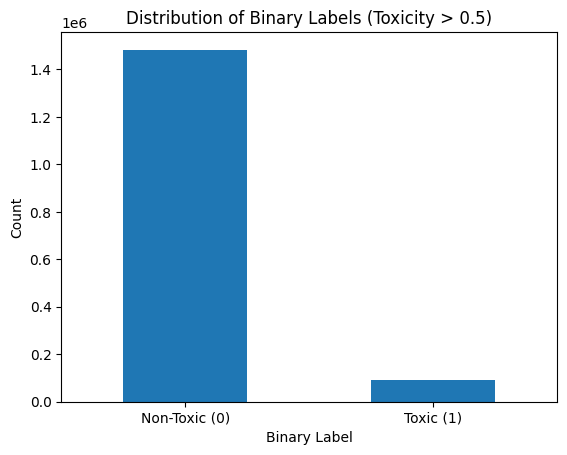

In [15]:
# Create a binary label for toxicity: 1 if toxicity > 0.5, else 0
df['binary_label'] = (df['toxicity'] > 0.5).astype(int)

# Check the binary label distribution
print("\nBinary Label Distribution:\n", df['binary_label'].value_counts())

# Optional: Visualize the distribution of the binary label
import matplotlib.pyplot as plt

df['binary_label'].value_counts().plot(kind='bar')
plt.title('Distribution of Binary Labels (Toxicity > 0.5)')
plt.xlabel('Binary Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Toxic (0)', 'Toxic (1)'], rotation=0)
plt.show()


In [16]:
# Specify the multi-label columns
multi_label_cols = ['severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']

# Convert multi-label columns to numeric and handle errors
for col in multi_label_cols:
    # Convert to numeric, setting invalid values to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill NaN with 0
    df[col] = df[col].fillna(0)

# Create binary labels for each multi-label column
for col in multi_label_cols:
    df[f'{col}_label'] = (df[col] > 0.5).astype(int)

# Display the first few rows of the binary labels
print("\nMulti-Label Columns with Binary Labels:\n", df[[f'{col}_label' for col in multi_label_cols]].head())




Multi-Label Columns with Binary Labels:
    severe_toxicity_label  obscene_label  sexual_explicit_label  \
0                      0              0                      0   
1                      0              0                      0   
2                      0              0                      0   
3                      0              1                      1   
4                      0              0                      0   

   identity_attack_label  insult_label  threat_label  
0                      0             0             0  
1                      0             1             0  
2                      0             1             0  
3                      0             1             0  
4                      0             0             0  


In [17]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['binary_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['binary_label'], random_state=42)

# Display dataset sizes
print("\nTraining Set Size:", len(train_df))
print("Validation Set Size:", len(val_df))
print("Test Set Size:", len(test_df))




Training Set Size: 1102054
Validation Set Size: 236154
Test Set Size: 236155


In [18]:
# Save processed datasets for later use
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

print("\nPreprocessed data saved as 'train_data.csv', 'val_data.csv', and 'test_data.csv'.")



Preprocessed data saved as 'train_data.csv', 'val_data.csv', and 'test_data.csv'.


In [19]:
# Load and check the saved train dataset
train_data = pd.read_csv('train_data.csv')

# Display basic information
print("\nLoaded Training Data Shape:", train_data.shape)
print("First 5 Rows of Training Data:\n", train_data.head())



Loaded Training Data Shape: (1102054, 54)
First 5 Rows of Training Data:
         id                                       comment_text  split  \
0  7111978  Sorry, if I am having a tough time believing t...   test   
1  6272647  You are obviously unaware that it gets its nam...  train   
2   809897  Good post, but the problem is that these citiz...  train   
3  6277765  Website looks way better now and is easier to ...  train   
4   371078  To all of you thinking that Walker cut the oil...  train   

                    created_date  publication_id  parent_id  article_id  \
0  2016-11-29 23:23:52.064514+00              53   635601.0      153390   
1  2017-11-02 12:34:18.688002+00              54  6271834.0      396108   
2  2017-01-08 19:13:02.264985+00              54   809834.0      160622   
3  2017-11-02 23:10:33.010043+00              54  6277517.0      396420   
4  2016-06-30 23:41:21.195327+00              21        0.0      140330   

     rating  funny  wow  ...  identity_an

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [21]:
# Load validation and test datasets
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')

# Extract features and labels
X_train = train_data['comment_text']
y_train = train_data['binary_label']

X_val = val_data['comment_text']
y_val = val_data['binary_label']

X_test = test_data['comment_text']
y_test = test_data['binary_label']


In [22]:
# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train.fillna(""))
X_val_tfidf = tfidf.transform(X_val.fillna(""))
X_test_tfidf = tfidf.transform(X_test.fillna(""))

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [23]:
# Validate the model
y_val_pred = lr_model.predict(X_val_tfidf)
print("\nValidation Performance - Logistic Regression:")
print(classification_report(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

# Test the model
y_test_pred = lr_model.predict(X_test_tfidf)
print("\nTest Performance - Logistic Regression:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


Validation Performance - Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    222448
           1       0.83      0.57      0.68     13706

    accuracy                           0.97    236154
   macro avg       0.90      0.78      0.83    236154
weighted avg       0.97      0.97      0.97    236154

Validation Accuracy: 0.96826647018471

Test Performance - Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    222448
           1       0.83      0.58      0.68     13707

    accuracy                           0.97    236155
   macro avg       0.90      0.79      0.83    236155
weighted avg       0.97      0.97      0.97    236155

Test Accuracy: 0.9684317503334674


In [24]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [25]:
# Tokenize and pad sequences
max_words = 20000  # Vocabulary size
max_len = 100  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train.fillna(""))
X_val_seq = tokenizer.texts_to_sequences(X_val.fillna(""))
X_test_seq = tokenizer.texts_to_sequences(X_test.fillna(""))

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [26]:
# Build LSTM/GRU model
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=True),  # Replace with GRU(64) for GRU
    Dropout(0.5),
    GRU(32),  # Remove or replace with Dense if only using LSTM
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [28]:
# Train the model
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_val_padded, y_val),
    epochs=5, batch_size=64
)


Epoch 1/5
17220/17220 ━━━━━━━━━━━━━━━━━━━━ 5385s 312ms/step - accuracy: 0.9580 - loss: 0.1432 - val_accuracy: 0.9721 - val_loss: 0.0781
Epoch 2/5
17220/17220 ━━━━━━━━━━━━━━━━━━━━ 5479s 316ms/step - accuracy: 0.9737 - loss: 0.0724 - val_accuracy: 0.9722 - val_loss: 0.0777
Epoch 3/5
17220/17220 ━━━━━━━━━━━━━━━━━━━━ 5399s 314ms/step - accuracy: 0.9771 - loss: 0.0631 - val_accuracy: 0.9712 - val_loss: 0.0811
Epoch 4/5
17220/17220 ━━━━━━━━━━━━━━━━━━━━ 5429s 314ms/step - accuracy: 0.9804 - loss: 0.0545 - val_accuracy: 0.9705 - val_loss: 0.0865
Epoch 5/5
17220/17220 ━━━━━━━━━━━━━━━━━━━━ 5442s 316ms/step - accuracy: 0.9835 - loss: 0.0467 - val_accuracy: 0.9699 - val_loss: 0.0930


In [29]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"\nTest Accuracy - LSTM/GRU: {accuracy * 100:.2f}%")

7380/7380 ━━━━━━━━━━━━━━━━━━━━ 358s 48ms/step - accuracy: 0.9696 - loss: 0.0919

Test Accuracy - LSTM/GRU: 97.00%
